## Data exploration
In this notebook, we will guide you through the steps of data exploreation/visualization that were used in the paper. We will also provide information about how to modify several parameters to perform your own analyses. While we focus on the dataset of the paper, this analysis pipeline can also be used to analyze your own data. Refer to the notebook dataset generation [to be done] and replace the path `'../Data/full_dataset.mat'` with your own data.

In [1]:
addpath('../Classes','../Functions')
set(0, 'defaultFigureRenderer', 'painters')
warning('off','all')

### Load the full dataset 
This will take a few seconds.
The supplied dataset contains all recordings that were used for the analyses performed in the paper. 

In [2]:
load('../Data/full_dataset.mat')

### Set parameters for the subsequent analysis
First, we have to decide which subset of the data we want to analyze and select the corresponding recordings accordingly. As we observed batch effects that were especially prominent in batch 3 (LNA experiment), we would advise to only pool batches 1 and 2, and regard batch 3 separately for the data exploreation. As we normlize the data for machine learning tasks, they can be pooled for later analyses.
For illustration purposes, we will use the main part of the dataset, which

Inclusion/exclusion of recordings is done by specifying keyword+parameter pairs. Commonly used ones would be:
- `PlatingDate` to include only specific batches (3 batches in total)
- `DIV` to include/exclude certain recording days (6,13,20,27,34)
- `Treatment` to include/exclude ntLNA/LNA treatment 


In [3]:
batches = unique([nw_array.PlatingDate]); %Refer to different batches via their PlatingDate property
inclusion = {{'PlatingDate',batches([1:2])}}; %e.g. specify the batches to analyze by indexing the batches array // here we use the first two
exclusion = {{'DIV',16}}; %example on how to exclude a certain recording day // here we don't exclude anything as DIV 16 does not exist

Set a flag to either consider ntLNA cultures as control or not. This should be set to 1 when comparing LNA to control cultures to increase the sample size.

In [4]:
eqLNAs = 1; % 1 uses ntLNA as control, 0 consideres them separate

Set different grouping variables; all combinations will be considered as a different group, e.g. {'Mutation'} would result in 2 groups (wt and a53t), while {'Mutation','Treatment'} would result in 4 (6 if eqLNAs = 0) groups (WT x control, WT x LNA, A53T x control, A53T x LNA)

In [5]:
grouping_conditions = {'Mutation'};% 'Treatment' would be another common option

Set outlier detection threshold (value refers to the median absolute deviation multiplier), which will be used to exclude single cells with extreme values to distort single-cell feature values:

In [6]:
th = 3; %default is 3

### Generate feature matrices
Split recordings by grouping conditions and calculate feature matrices

In [7]:
[tmp_matrix,tmp_sd,nw_matrix,nw_sd,leg,tps] = generate_feature_matrices(eqLNAs,nw_array,tmp_vars,nw_vars,grouping_conditions,th);

### Timeline plots
Let's take a look at the data! We start with the single cell features:

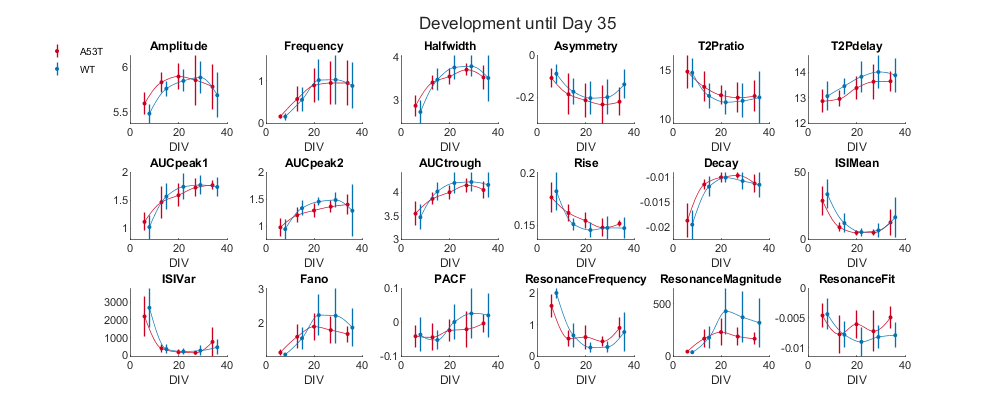

In [8]:
%plot --size 1000,400
f = plot_features(tmp_vars,tmp_matrix,tmp_sd,tps,leg);

Quite a few differences, now let's check the network features:

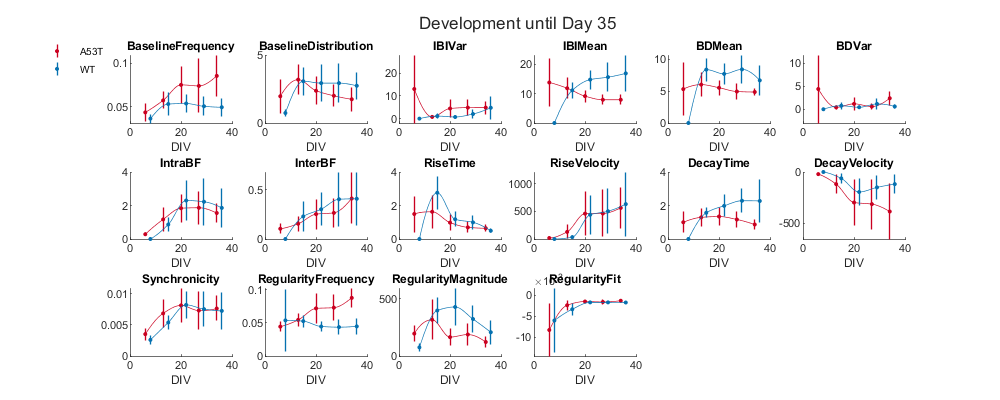

In [9]:
%plot --size 1000,400
f = plot_features(nw_vars,nw_matrix,nw_sd,tps,leg);

### Heatmaps
Even more pronounced! But maybe a more condensed plot would give us a better impression. Heatmaps look like an intuitive solution, but first we have to choose two conditions to compare:

In [ ]:
fprintf('Available conditions are %s',strjoin(leg,' '))

Here we only have two conditions, so we can just go ahead with them. If you have selected more groups, than you need to specify them accordingly, correspdonding to their position in the `leg` array:

In [11]:
idx1 = 1; %Reference value corresponding to the position in the leg variable
idx2 = 2; %Comparison via ratio: value(idx2)/value(idx1)

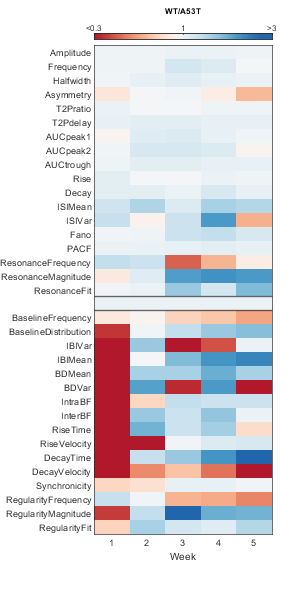

In [12]:
%plot --size 300,600
heatmap_plot(tmp_matrix,tmp_vars,nw_matrix,nw_vars,idx1,idx2,leg)

### PCA
Now that we have seen quite extensive differences between the two genotypes, we also want to check if they are consistent within and between different feature classes. PCA analyses will allow us to quantify and visualize that conveniently. First, we have to specify if we want to analze the full developmentaltrajectory or only parts of it:

In [13]:
MIN_AGE = 0; %Lowest DIV to be included
MAX_AGE = 35; %Highest DIV to be included

Having specified the time do be considered for the PCA, we can check all different subgroups of features:

In [13]:
featureGroup = "[sc_mat]"; %Here we only consider single-cell features
[sc_color,sc_mat,~] = preparePCAinput(nw_array,MIN_AGE,MAX_AGE,featureGroup,th);

featureGroup = "[nw_mat]"; %Here we only consider network features
[nw_color,nw_mat,~] = preparePCAinput(nw_array,MIN_AGE,MAX_AGE,featureGroup,th);

featureGroup = "[sc_mat, nw_mat]"; %Here we use both single-cell and network features
[all_color,all_mat,~] = preparePCAinput(nw_array,MIN_AGE,MAX_AGE,featureGroup,th);

Finally, we can visualize the data:

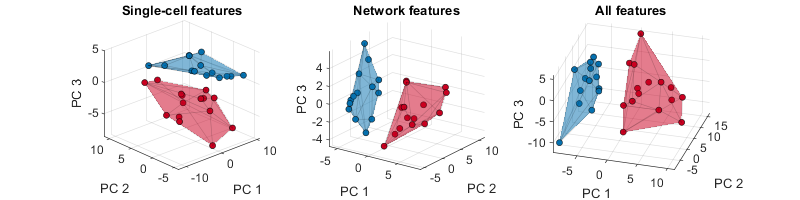

In [14]:
%plot --size 800,200
viewAngle = [16 37]; %Play around with those as plots are unfortunately not interactive
markerSize = 20;
onlyArea = 0;


figure('Color','w');

viewAngle = [-43 27];
subplot(131);
plotPCA(sc_mat,sc_color,[],[],viewAngle,markerSize,onlyArea);
title('Single-cell features')

viewAngle = [35 22];
subplot(132);
plotPCA(nw_mat,nw_color,[],[],viewAngle,markerSize,onlyArea);
title('Network features')

viewAngle = [16 37];
subplot(133);
plotPCA(all_mat,all_color,[],[],viewAngle,markerSize,onlyArea);
title('All features')

Now that we've gotten a good impression of what our data looks like, we might be interested in understanding which features can differentiate between these different groups. Let's head straight into the [classification analysis!](classification_analysis.ipynb)
